100%|███████████████████████████████████████| 1000/1000 [11:37<00:00,  1.43it/s]


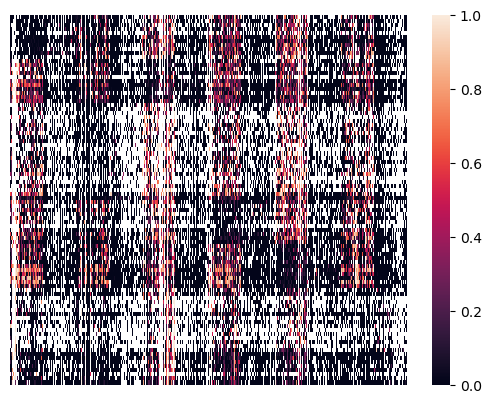

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
from tqdm import tqdm
metadata = pd.read_csv("metadata.csv")
import re
pattern = re.compile("^[1-9][0-9]M")
import warnings
warnings.filterwarnings("ignore")
from helper_functions import *
# outputdir = "outputdir_02102023"
outputdir = "outputdir_23102023_hypo_hyper"
os.system("mkdir -p {}".format(outputdir))

path_to_02_output = os.path.join("outputdir_02102023", "02_output")
# path_to_03_output = os.path.join(outputdir, "03_output_abs_logFC")
# path_to_03_output = os.path.join(outputdir, "03_output")
path_to_03_output = os.path.join(outputdir, "03_output_noFDR")

os.system("mkdir -p {}".format(path_to_03_output))

# atlas_sample_types = "Tissue"
# topK = 500
# for topK in [500, 1000]:
#     for atlas_sample_types in ["Tissue", "Tissue,WBC", "Tissue,WBC,Control", "Tissue,Control"]:
for topK in [500]:
    for atlas_sample_types in ["Tissue,WBC"]:
        path_to_ttestres = os.path.join(path_to_02_output, atlas_sample_types.replace(",", "_and_"), "summary_of_all_ttest_results.csv")
        
        LOO_sample = "not_given"
        
        resdf = pd.read_csv(path_to_ttestres, header = None)
        resdf.columns = summ_file_columns[atlas_sample_types].split(",")
        
        selected_regions = dict()
        
        for group in atlas_labels[atlas_sample_types]:
            resdf["{}_abslogFC".format(group)] = resdf["{}_logFC".format(group)].apply(lambda x: abs(x))
            # selected_regions[group] = resdf[resdf["{}_pval".format(group)] <= 0.05/1e6].sort_values(by = "{}_abslogFC".format(group), ascending = False).head(topK)["region"].to_list()
            # selected_regions[group] = resdf[resdf["{}_pval".format(group)] <= 0.05/1e6].sort_values(by = "{}_logFC".format(group), ascending = True).head(topK)["region"].to_list()
            # selected_regions[group] = resdf[resdf["{}_pval".format(group)] <= 0.05].sort_values(by = "{}_logFC".format(group), ascending = True).head(topK)["region"].to_list()
            selected_regions[group] = resdf[resdf["{}_pval".format(group)] <= 0.05].sort_values(by = "{}_logFC".format(group), ascending = True).head(topK)["region"].to_list() + resdf[resdf["{}_pval".format(group)] <= 0.05].sort_values(by = "{}_logFC".format(group), ascending = True).tail(topK)["region"].to_list()
        
        path_to_save_betadf = os.path.join(path_to_03_output, "top{}_atlas_{}.csv".format(topK, atlas_sample_types.replace(",", "_and_")))
        
        selected_sample_types = atlas_sample_types.split(",")
        selected_metadata = metadata[metadata["Sample type"].isin(selected_sample_types)]
        
        if os.path.exists(path_to_save_betadf) == False:
            all_betadf = pd.DataFrame(data = [item for item in selected_metadata["filename"].to_list()], columns = ["sample"])
            for label in selected_regions.keys():
                for region in tqdm(selected_regions[label]):
                    df = pd.DataFrame()
                    if "," in atlas_sample_types:
                        selected_sample_types = atlas_sample_types.split(",")
                        selected_metadata = metadata[metadata["Sample type"].isin(selected_sample_types)]
                        for sampletype in selected_sample_types:
                            assert sampletype in ["Tissue", "WBC", "cfDNA", "Control"]
                            tmpdf = pd.read_csv(os.path.join(readdf_dir[sampletype], "read_at_region_{}.csv".format(region)), index_col = [0])
                            df = pd.concat([df, tmpdf], axis = 0)
                    elif (atlas_sample_types == "cfDNA"):
                        selected_sample_types = ["cfDNA", "Control"]
                        selected_metadata = metadata[metadata["Sample type"].isin(selected_sample_types)]
                        for sampletype in selected_sample_types:
                            assert sampletype in ["Tissue", "WBC", "cfDNA", "Control"]
                            tmpdf = pd.read_csv(os.path.join(readdf_dir[sampletype], "read_at_region_{}.csv".format(region)), index_col = [0])
                            df = pd.concat([df, tmpdf], axis = 0)
                    else:
                        assert atlas_sample_types in ["Tissue", "WBC", "cfDNA", "Control"]
                        df = pd.read_csv(os.path.join(readdf_dir[atlas_sample_types], "read_at_region_{}.csv".format(region)), index_col = [0])
                        selected_metadata = metadata[metadata["Sample type"] == atlas_sample_types]
                    
                    if (LOO_sample != "not_given" and LOO_sample in metadata.filename.unique()):
                        df = df[df["Sample"] != LOO_sample]
                    
                    if df.shape[0] != 0:
                        region_chrom = region.split("_")[0]
                        region_start = int(region.split("_")[1])
                        region_end = int(region.split("_")[2])
                                        
                        df["label"] = df["sample"].apply(lambda x: metadata[metadata["filename"] == x]["Label"].unique()[0])
                        
                        df["check_cigar"] = df["cigar"].apply(lambda x: bool(pattern.fullmatch(x)))
                        df = df[df["check_cigar"] == True]
                        
                        df["Label"] = df["sample"].apply(lambda x: metadata[metadata["filename"] == x]["Label"].unique()[0])
                                        
                        df["end"] = df[["start", "cigar"]].apply(lambda x: int(x[0]) + int(x[1].replace("M", "")), axis = 1)
                        
                        path_to_all_fa = "/datassd/hieunguyen/ECD/storage/resources/hg19"
                        ##### HELPER FUNCTIONS
                        def get_refseq(path_to_all_fa, chrom, start, end):
                            import pyfaidx
                            refseq = pyfaidx.Fasta(os.path.join(path_to_all_fa, "chr{}.fa".format(chrom)))
                            return(str.upper(refseq.get_seq(name = "chr{}".format(chrom), start = start, end = end).seq))
                        
                        refseq_at_cluster = get_refseq(path_to_all_fa = path_to_all_fa, 
                                                        chrom = region_chrom, 
                                                        start = region_start, 
                                                        end = region_end + 1)
                        all_cpg_in_cluster = [m.start(0) for m in re.finditer("CG", refseq_at_cluster)]
                        cpg_coords = [item + region_start for item in all_cpg_in_cluster]
                        
                        def get_CpG_status(read_start, read_end, read, cpg_pos, mode = "string"):    
                            if (read_start <= cpg_pos) and (read_end >= cpg_pos):
                                seq = read[cpg_pos - read_start: cpg_pos + 1 - read_start + 1]
                            else:
                                seq = "not_covered"
                            if mode == "string":
                                return seq
                            elif mode == "num":
                                if seq == "not_covered":
                                    seq = -1
                                elif seq == "CG":
                                    seq = 1
                                else:
                                    seq = 0
                                return seq
                        for cpg_pos in cpg_coords:
                            df[cpg_pos] = df[["start", "end", "seq"]].apply(lambda x: get_CpG_status(x[0], x[1], x[2], cpg_pos, mode = "num"), axis = 1)
                        
                        betadf = selected_metadata[["filename"]].copy()
                        betadf.columns = ["sample"]
                        
                        for cpg_pos in cpg_coords:    
                            tmpdf = df[["sample", cpg_pos, "Label"]].copy()
                            tmpcountdf = tmpdf.groupby('sample')[cpg_pos].apply(lambda x: (x == 1).sum()/((x == 0).sum() + (x == 1).sum()) ).reset_index(name= "meth_level_{}".format(cpg_pos))
                            betadf = betadf.merge(tmpcountdf[["sample", "meth_level_{}".format(cpg_pos)]], right_on = "sample", left_on = "sample", how = "outer")
                        
                        betadf["avg_beta"] = betadf[[item for item in betadf.columns if item != "sample"]].apply(lambda x: np.mean([item for item in x if np.isnan(item) == False]), axis = 1)
                        betadf["label"] = betadf["sample"].apply(lambda x: metadata[metadata["filename"] == x]["Label"].unique()[0])
                    betadf = betadf[["sample", "avg_beta"]]
                    betadf.columns = ["sample", region]
                    all_betadf = all_betadf.merge(betadf[["sample", region]], right_on = "sample", left_on = "sample")
                    
            all_betadf["label"] = all_betadf["sample"].apply(lambda x: metadata[metadata["filename"] == x]["Label"].unique()[0])
            
            all_betadf.to_csv(path_to_save_betadf)
        else:
            all_betadf = pd.read_csv(path_to_save_betadf, index_col = [0])
        
        plotdf = pd.concat([
            all_betadf[all_betadf["label"] == "Liver"],
            all_betadf[all_betadf["label"] == "Gastric"],
            all_betadf[all_betadf["label"] == "Breast"],
            all_betadf[all_betadf["label"] == "Lung"],
            all_betadf[all_betadf["label"] == "CRC"],
            all_betadf[all_betadf["label"] == "WBC"],
            all_betadf[all_betadf["label"] == "Control"],
        ], axis = 0)
        
        sns.heatmap(plotdf.drop(["sample", "label"], axis = 1))
        plt.xticks([])
        plt.yticks([])
        plt.show()
        
        plotdf.to_csv(os.path.join(path_to_03_output, "top{}_atlas_{}.final.csv".format(topK, atlas_sample_types)))
        regiondf = pd.DataFrame(data = list(set([item.replace("_x", "").replace("_y", "") for item in plotdf.columns if item not in ["sample", "label"]])), columns = ["region"])
        regiondf["region"] = regiondf["region"].apply(lambda x: "{}:{}-{}".format(x.split("_")[0], x.split("_")[1], x.split("_")[2]))
        regiondf.to_csv(os.path.join(path_to_03_output, "top{}_atlas_{}.final_Region.csv".format(topK, atlas_sample_types)), header = False, index = False, sep = "\t")